In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import config

In [2]:
color_palette = ['#4E79A7', '#F28E2C', '#E15759']

In [3]:
def load_eval_data(data_path: str) -> pd.DataFrame:
    with open(data_path, 'r') as f:
        model_evaluation_results = [dict(tmp_tuple) for tmp_tuple in
                                    {tuple(tmp_dict.items()) for tmp_dict in json.load(f)}]

    model_evaluation_results = list(map(lambda x: {
        'Coherence': x.get('coherence_adjusted', None),
        'Consistency': x.get('consistency_adjusted', None),
        'Fluency': x.get('fluency_adjusted', None),
        'Relevance': x.get('relevance_adjusted', None),
    }, model_evaluation_results))

    return pd.DataFrame(model_evaluation_results)


base_data = load_eval_data(f'{config.G_EVAL_DIR}/model_evaluation_results_base_scored.json')
ft_data = load_eval_data(f'{config.G_EVAL_DIR}/model_evaluation_results_ft_scored.json')
dpo_data = load_eval_data(f'{config.G_EVAL_DIR}/model_evaluation_results_dpo_scored.json')

In [4]:
combined_df = pd.concat([base_data, ft_data, dpo_data], axis=0, ignore_index=True)
scaler = MinMaxScaler()
scaler.fit(combined_df)

base_data[base_data.columns] = scaler.transform(base_data)
ft_data[base_data.columns] = scaler.transform(ft_data)
dpo_data[base_data.columns] = scaler.transform(dpo_data)

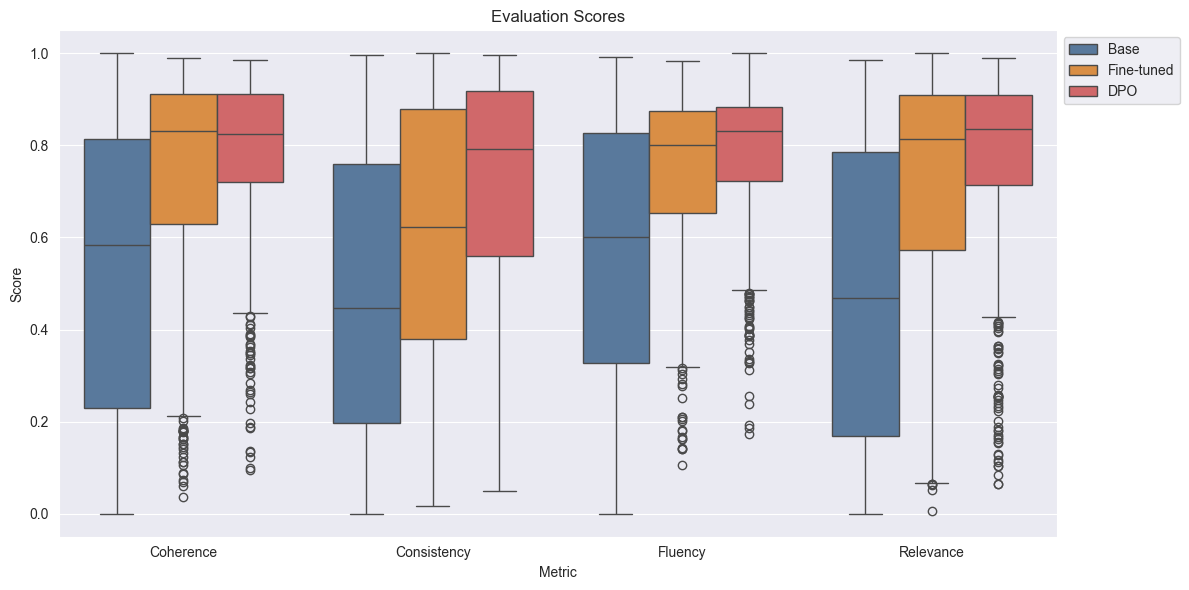

In [7]:
def create_grouped_boxplot(base_data, ft_data, dpo_data, title):
    base_melt = base_data.melt(var_name='Column', value_name='Value')
    base_melt['DataFrame'] = 'Base'

    ft_melt = ft_data.melt(var_name='Column', value_name='Value')
    ft_melt['DataFrame'] = 'Fine-tuned'

    dpo_melt = dpo_data.melt(var_name='Column', value_name='Value')
    dpo_melt['DataFrame'] = 'DPO'

    combined_data = pd.concat([base_melt, ft_melt, dpo_melt], ignore_index=True)

    plt.figure(figsize=(12, 6))
    sns.set_palette(color_palette)
    
    sns.boxplot(x='Column', y='Value', hue='DataFrame', data=combined_data)

    plt.title(title)
    plt.xlabel('Metric')
    plt.ylabel('Score')

    plt.legend(title='', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage
create_grouped_boxplot(base_data, ft_data, dpo_data, "Evaluation Scores")

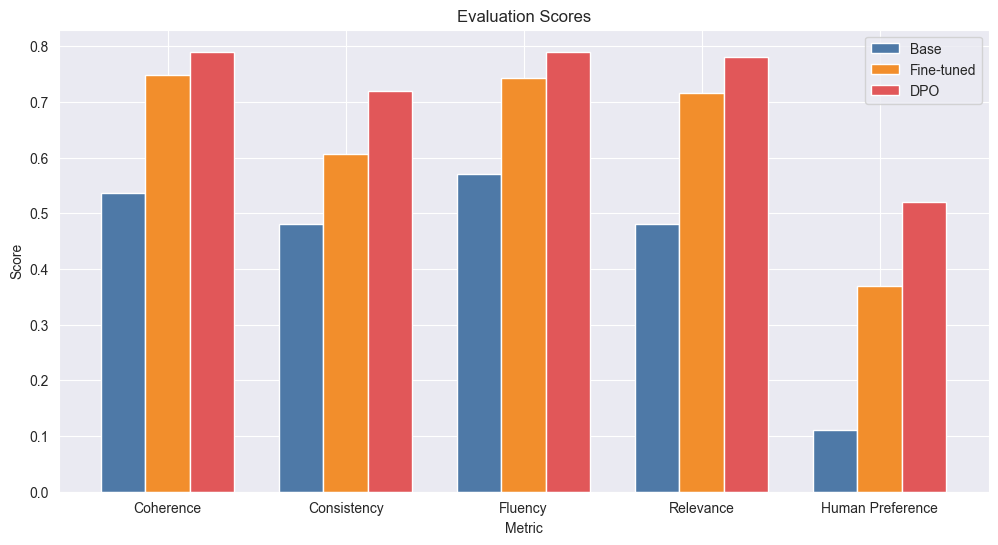

In [8]:
def create_grouped_bar_chart(base_data, ft_data, dpo_data, human_preference_data, title):
    bar_width = 0.25
    base_data["Human Preference"] = human_preference_data["base"]
    ft_data["Human Preference"] = human_preference_data["fine_tuned"]
    dpo_data["Human Preference"] = human_preference_data["dpo"]

    r1 = np.arange(len(base_data.columns))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.figure(figsize=(12, 6))

    plt.bar(r1, base_data.mean(), color=color_palette[0], width=bar_width, label='Base')
    plt.bar(r2, ft_data.mean(), color=color_palette[1], width=bar_width, label='Fine-tuned')
    plt.bar(r3, dpo_data.mean(), color=color_palette[2], width=bar_width, label='DPO')

    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks([r + bar_width for r in range(len(base_data.columns))], base_data.columns)

    plt.legend()
    plt.show()


human_preference_data = {
    'base': 0.11,
    'fine_tuned': 0.37,
    'dpo': 0.52
}

create_grouped_bar_chart(base_data, ft_data, dpo_data, human_preference_data, "Evaluation Scores")